In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data Wrangling
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import flammkuchen as fl
from tqdm import tqdm

# Image
import cv2 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from collections import defaultdict

In [4]:
from fig_1_helper import labels_cat, color, color_bouts, cmp_bouts
from fig_1_helper import mid_head
from qc_helpers import calculate_percentage, calculate_percentage_lists, smooth_bool_array, quantify_periods, median_length_periods

# Load Data

In [5]:
figure_path = Path(r"\\portulab.synology.me\data\Kata\Figures_Paper\Figure_1\supp\suppl_1")

In [6]:
fish_path = Path(r'\\portulab.synology.me\data\Kata\Data\230307_visstim_2D\120328_f3')
fish_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3')

In [7]:
vid_path = list(fish_path.glob('*video*'))[0]
vid_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3/120328_video.mp4')

In [8]:
path_features = Path(r'\\portulab.synology.me\data\Kata\Processed_Data\tensor_data\features_bouts_new.csv')
path_features

WindowsPath('//portulab.synology.me/data/Kata/Processed_Data/tensor_data/features_bouts_new.csv')

In [9]:
features = pd.read_csv(path_features)
features.head()

,Unnamed: 0,exp,fish_id,bout_angle,cluster,frame_start,frame_end,bout_id_orig,mb_proba,max_eye_rot,...,tail_freq,l_fin_freqs,r_fin_freqs,tail_max_freq,l_fin_max_freqs,r_fin_max_freqs,l_start,l_end,r_start,r_end
0,0,13052024_visstim_2D_round,240513_f0,3.000171,0,18375,18410,78,0.806645,-0.239648,...,0.121622,0.105263,0.109756,0.166667,0.166667,0.166667,0.0,27.0,0.0,28.0
1,1,13052024_visstim_2D_round,240513_f0,1.649302,0,19461,19484,80,1.000000,0.479035,...,0.058140,0.117647,0.119048,0.166667,0.166667,0.250000,0.0,15.0,7.0,26.0
2,2,13052024_visstim_2D_round,240513_f0,-0.861132,0,19661,19689,81,1.000000,-1.120168,...,0.097561,0.115385,0.104167,0.166667,0.166667,0.125000,4.0,20.0,0.0,27.0
3,3,13052024_visstim_2D_round,240513_f0,0.870591,0,20257,20292,84,1.000000,-2.662451,...,0.114286,0.117647,0.117647,0.166667,0.166667,0.125000,19.0,35.0,0.0,35.0
4,4,13052024_visstim_2D_round,240513_f0,2.231631,0,20824,20859,86,1.000000,-1.192489,...,0.108108,0.116667,0.103448,0.166667,0.125000,0.125000,0.0,23.0,6.0,28.0


In [10]:
clusters = features.cluster.astype(int)

### Set some Parameters

In [11]:
center_y = 512 #268  #from camera
center_x = 640 #360  #from camera
px_mm = 70 #150 #70

contrast = 2.2 # Contrast control ( 0 to 127)
brightness = 0.01 # Brightness control (0-100)

In [12]:
alph=0.3
size=1
cm_ = 1/2.54  # centimeters in inches
f_size =6
lw=0.5
dpi= 600

# Panel A: Trajectory

In [13]:
traj_paths = [
    Path(r'//portulab.synology.me/data/Kata/Data/22042024_visstim_2D_round/240423_f0'),
    Path(r'//portulab.synology.me/data/Kata/Data/22042024_visstim_2D_round/240424_f4_1'),
    Path(r'//portulab.synology.me/data/Kata/Data/22042024_visstim_2D_round/240423_f0_1'),
    Path(r'//portulab.synology.me/data/Kata/Data/22042024_visstim_2D_round/240424_f4_2'),]

mask_path = Path(r"\\portulab.synology.me\data\Kata\Processed_Data\22042024_visstim_2D_round_\filtered\22042024_visstim_2D_round_mask.csv")

In [14]:
m_x_lists = []
m_y_lists = []

for path in traj_paths:
    motor_path = list(path.glob('*motor_log.hdf5*'))[0]
    motor_log = pd.read_hdf(motor_path)
    m_x_lists.append(motor_log.x.values)
    m_y_lists.append(motor_log.y.values)

In [15]:
for i in m_x_lists:
    print ('Experiment lenghts {} min'.format(i.shape[0]/200/60))

Experiment lenghts 9.252 min
Experiment lenghts 9.362583333333333 min
Experiment lenghts 7.980333333333333 min
Experiment lenghts 8.794833333333335 min


In [16]:
mask= fl.load(mask_path)

margin = mask[3]
center_x_mask = mask[0]-0.5
center_y_mask = mask[1]+0.5
radius_mask = mask[2]+0.3

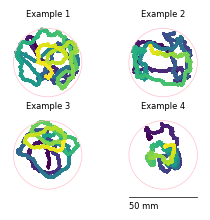

In [17]:
viridis = cm.get_cmap('viridis')
vmin, vmax = 0, 10

fig, axes = plt.subplots(2, 2, facecolor='None',figsize=(5.6*cm_, 5.6*cm_), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(4):
    axes[i].set_title('Example {}'.format(i+1), fontsize=f_size)
    # Generate time points for each series
    time_points = np.linspace(0, 10, m_x_lists[i].shape[0])
    norm = plt.Normalize(vmin, vmax)
    colors = viridis(norm(time_points))
    
    sc= axes[i].scatter(m_x_lists[i], m_y_lists[i], s=size, c=colors)
    circle = plt.Circle((center_x_mask, center_y_mask), radius_mask, lw=lw, color='pink', fill=False)
    axes[i].add_patch(circle)
    axes[i].axis('off')
    axes[i].set_aspect('equal')  # Set aspect ratio to equal


axes[-1].plot([center_x_mask-radius_mask,center_x_mask+radius_mask], [-40, -40], lw=lw, c='k')
axes[-1].text(center_x_mask-radius_mask, -50, '50 mm', fontsize= f_size)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

fig.savefig(figure_path/ 'example_trajectories_sq.png', dpi=dpi)

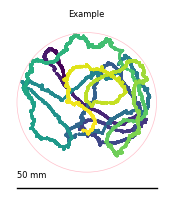

In [57]:
viridis = cm.get_cmap('viridis')
# Set your min and max for the color scale
vmin, vmax = 0, 10

fig, axes = plt.subplots(facecolor='None',figsize=(5*cm_, 5.5*cm_))

axes.set_title('Example', fontsize=f_size)
# Generate time points for each series
time_points = np.linspace(0, 10, m_x_lists[0].shape[0])
norm = plt.Normalize(vmin, vmax)
colors = viridis(norm(time_points))

sc= axes.scatter(m_x_lists[0], m_y_lists[0], s=size, c=colors)
circle = plt.Circle((center_x_mask, center_y_mask), radius_mask, lw=lw, color='pink', fill=False)
axes.add_patch(circle)
axes.axis('off')
axes.set_aspect('equal')  # Set aspect ratio to equal
axes.plot([center_x_mask-radius_mask,center_x_mask+radius_mask], [-40, -40], lw=lw*2, c='k')
axes.text(center_x_mask-radius_mask, -35, '50 mm', fontsize= f_size)
    
plt.tight_layout()
fig.savefig(figure_path/ 'example_trajectories_single_fish.png', dpi=dpi)


## Panel B: Tracking Overlay

In [19]:
fish_path = Path(r'\\portulab.synology.me\data\Kata\Data\230307_visstim_2D\120328_f3')
fish_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3')

In [20]:
df_dlc = pd.read_csv(Path('//portulab.synology.me/data/Kata/Processed_Data/22042024_visstim_2D_round_/240423_f0_DLC.csv'), header=[0,1])
thr =0.95
body_l = df_dlc.body.likelihood
mask = body_l >=thr

## pixel error
mid_headx, mid_heady, left_mid_eye_x, left_mid_eye_y, right_mid_eye_x, right_mid_eye_y = mid_head(df_dlc)
head_x_ =mid_headx[mask==True]
head_y_ =mid_heady[mask==True]

In [21]:
vid_path = list(fish_path.glob('*video*'))[0]
vid_path

WindowsPath('//portulab.synology.me/data/Kata/Data/230307_visstim_2D/120328_f3/120328_video.mp4')

In [22]:
## Read in chunk of video 

frame_n = 5000

frames= []

cap = cv2.VideoCapture(str(vid_path))
for i in tqdm(range(frame_n)):
    success = cap.grab()
    ret, image = cap.retrieve()
    frames.append(image)
    
cap.release()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 340.95it/s]


In [23]:
bout_frame = 4212

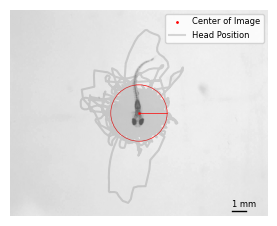

In [27]:
frame_n = bout_frame+15
img = frames[frame_n]
rot_im = img
### Make a lighter figure
out = cv2.addWeighted(rot_im, contrast, rot_im, 0, brightness)

# Create figure and axes
fig, ax = plt.subplots( facecolor='None',figsize=(13*cm_, 6.8*cm_))
                       
# Display the image
ax.imshow(out, alpha=0.9, cmap='gray') #plus 15 to see bend tail etc
ax.scatter(center_x, center_y, c='r', s=size, label='Center of Image')
ax.plot(head_x_, head_y_, alpha=alph, color='gray', label ='Head Position')

ax.plot([1100, 1170], [1000, 1000], lw=lw*2, c='k')
ax.text(1100, 980, '1 mm', fontsize=f_size)

ax.plot([center_x, center_x+140], [center_y, center_y], lw=lw, c='r')
circle = plt.Circle((center_x, center_y), 140,
                    color='r', fill=False, lw=lw)
ax.add_patch(circle)
plt.legend(fontsize=f_size)
ax.axis('off')

fig.savefig(figure_path/'traj_tracked_frame_tracking_error.png', dpi = dpi)
fig.savefig(figure_path/'traj_tracked_frame_tracking_error.pdf', dpi = dpi)

## Panel C: Tracking Error

In [28]:
dict_paths = list(Path('//portulab.synology.me/data/Kata/Processed_Data/tracking_assessment').glob('*QC_tracking.h5'))

pooled_dicts = []
for path in dict_paths:
    dict =fl.load(path)
    pooled_dicts.append(dict)

flattened_dicts = [item for sublist in pooled_dicts for item in sublist]
len(flattened_dicts), type(flattened_dicts)
combined_dict = defaultdict(list)

for d in flattened_dicts:
    for key, value in d.items():
        combined_dict[key].append(value)

# Convert defaultdict back to a regular dictionary
combined_dict = {key: value for key, value in combined_dict.items()}
print(combined_dict.keys())

dict_keys(['clusters_per_px_error', 'periods', 'px_error', 'Median_lengh_non_tracking_s', 'Median_lengh_tracking_s', 'fish_id', 'l_r_tracked_frames', 'l_tracked_frames', 'r_tracked_frames', 'total_frames', 'tracked_frames'])


In [29]:
flattened_error = [item for sublist in combined_dict['px_error'] for item in sublist]
len(flattened_error)
print ("Median px error {}".format(np.median(flattened_error)))
print ("Median micron error {}".format((np.median(flattened_error)/px_mm)*100))

Median px error 6.3850099988928655
Median micron error 9.121442855561236


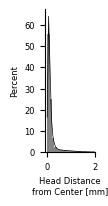

In [33]:
plt.figure( facecolor='None',figsize=(3*cm_, 5.5*cm_))
ax = sns.histplot(data=np.asarray(flattened_error) / px_mm, bins=np.arange(0, 2, 0.1), edgecolor='w',stat='percent', color='k', kde=True)
for line in ax.get_lines():
    line.set_linewidth(lw) 

plt.ylabel('Percent', fontsize=f_size)
plt.xlabel('Head Distance\nfrom Center [mm]', fontsize=f_size)
plt.tick_params(axis='both', which='major', labelsize=f_size)
plt.axvline(140/px_mm, ls=':', c='r', lw=lw)
plt.xlim(-0.1,2)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig(figure_path/ 'hist_px_error_pooled.pdf', dpi =600)
plt.savefig(figure_path/ 'hist_px_error_pooled.png', dpi =600)

## Panel D: Tracking Error across categories

In [34]:
flattened_clust = [item for sublist in combined_dict['clusters_per_px_error'] for item in sublist]
px_error_per_cluster = []

for clust in range(11):
    px_per_cluster = np.asarray(flattened_error)[np.asarray(flattened_clust)==clust]
    px_error_per_cluster.append(px_per_cluster)

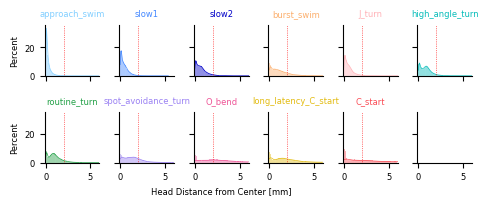

In [36]:
# Plotting as PDF
fig, axes = plt.subplots(2, 6, facecolor='None',figsize=(12.5*cm_, 5.5*cm_), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(11):
    ax = sns.histplot(data=np.asarray(px_error_per_cluster[i]) / px_mm, 
                 bins=np.arange(0, 6, 0.1), color=color[i], edgecolor='w', kde=True, 
                 stat='percent', ax=axes[i])
    for line in ax.get_lines():
        line.set_linewidth(lw)  # Set the desired line width here
    axes[i].set_title(labels_cat[i], color=color[i], fontsize=f_size)
    axes[i].axvline(140 / px_mm, lw=lw, ls=':', c='r')
    axes[i].set_xlim(-0.1, 6)
    axes[i].set_ylim(-0.1, 36)

axes[0].set_ylabel('Percent', fontsize=f_size)
axes[6].set_ylabel('Percent', fontsize=f_size)
axes[-4].set_xlabel('Head Distance from Center [mm]', fontsize=f_size)
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig(figure_path / 'hist_px_error_pooled_per_bout_cat_all.pdf', dpi=dpi)
fig.savefig(figure_path / 'hist_px_error_pooled_per_bout_cat_all.png', dpi=dpi)

## Panel E-F: Tracking and Searching Episodes

In [37]:
periods = combined_dict['periods']
len(periods)

97

In [38]:
# Initialize pooled histograms
true_hist_pooled = np.zeros(10)
false_hist_pooled = np.zeros(10)

bins = np.arange(1, 12, 1)  # Bins from 0 to 10 with step of 1
# print (bins)

for i in range(len(periods)):
    # Separate numbers based on the boolean value
    true_numbers = [number for flag, number in periods[i] if flag]
    false_numbers = [number for flag, number in periods[i] if not flag]
    
    # Convert to minutes
    true_numbers_min = [(item/200) / 60 for item in true_numbers]
    false_numbers_min = [(item/200) / 60 for item in false_numbers]

    # Create histograms for each period and add to pooled histograms
    true_hist, _ = np.histogram(true_numbers_min, bins=bins)
    false_hist, _ = np.histogram(false_numbers_min, bins=bins)
    
    true_hist_pooled += true_hist
    false_hist_pooled += false_hist

In [39]:
true_hist_pooled.shape, bins.shape

((10,), (11,))

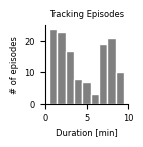

In [41]:

fig, ax = plt.subplots(facecolor='None',figsize=(4*cm_, 4*cm_))

ax.bar(bins[:-1], true_hist_pooled, width=1, color='gray', edgecolor='w')
ax.set_title('Tracking Episodes', fontsize=f_size)
ax.set_xlabel('Duration [min]', fontsize=f_size)
ax.set_ylabel('# of episodes', fontsize=f_size)
ax.set_xlim(0, 10)
# Set the size of tick labels.
ax.tick_params(axis='both', which='major', labelsize=f_size)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig(figure_path/ 'lengh_tracking_pooled.pdf', dpi =dpi)
fig.savefig(figure_path/ 'lengh_tracking_pooled.png', dpi =dpi)

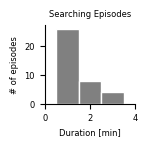

In [42]:
fig, ax = plt.subplots(facecolor='None',figsize=(4*cm_, 4*cm_))

ax.bar(bins[:-1], false_hist_pooled, width=1, color='gray', edgecolor='w')
ax.set_title('Searching Episodes', fontsize=f_size)
ax.set_xlabel('Duration [min]', fontsize=f_size)
ax.set_ylabel('# of episodes', fontsize=f_size)
ax.set_xlim(0, 4)
# Set the size of tick labels.
ax.tick_params(axis='both', which='major', labelsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig(figure_path/ 'lengh_searching_pooled.pdf', dpi =dpi)
fig.savefig(figure_path/ 'lengh_searching_pooled.png', dpi =dpi)

## quantify what percentage of search episodes is under 1 min

In [43]:
# Initialize counters for total and under 1 minute search episodes
total_search_episodes = 0
under_1_min_search_episodes = 0

for i in range(len(periods)):
    # Separate numbers based on the boolean value
    false_numbers = [number for flag, number in periods[i] if not flag]
    
    # Convert to minutes
    false_numbers_min = [item / 60 for item in false_numbers]
    
    # Update total and under 1 minute counters
    total_search_episodes += len(false_numbers_min)
    under_1_min_search_episodes += sum(1 for number in false_numbers_min if number < 1)

# Calculate percentage
percentage_under_1_min = (under_1_min_search_episodes / total_search_episodes) * 100

print(f"Percentage of search episodes under 1 minute: {percentage_under_1_min:.2f}%")


Percentage of search episodes under 1 minute: 68.31%


## Panel H-G:  Frames tracked

In [44]:
### unpack frames 

total_frames = combined_dict['total_frames']
tracked_frames = combined_dict['tracked_frames']
l_tracked_frames = combined_dict['l_tracked_frames']
r_tracked_frames = combined_dict['r_tracked_frames']
both_tracked_frames = combined_dict['l_r_tracked_frames']
len(total_frames), len(both_tracked_frames)

(97, 97)

In [45]:
### calculate percentages
tracked_frames_perc = calculate_percentage_lists(tracked_frames, total_frames)
tracked_l_fins_perc = calculate_percentage_lists(l_tracked_frames, tracked_frames)
tracked_r_fins_perc = calculate_percentage_lists(r_tracked_frames, tracked_frames)
l_r_tracked_frames_perc = calculate_percentage_lists(both_tracked_frames, tracked_frames)

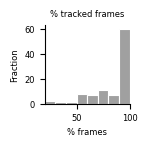

In [51]:
bins=np.arange(0,110,10)

fig, ax = plt.subplots(facecolor='None',figsize=(4*cm_, 4*cm_))

sns.histplot(data=tracked_frames_perc, bins=bins, edgecolor='w', color='gray', kde=False)
ax.set_title('% tracked frames', fontsize=f_size)
ax.set_ylabel('Fraction', fontsize=f_size)
ax.set_xlabel('% frames', fontsize=f_size)
ax.set_xlim(20,100)
# Set the size of tick labels.
ax.tick_params(axis='both', which='major', labelsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig( figure_path / 'tracked_frames_percent_pooled.pdf', dpi =dpi)
fig.savefig( figure_path / 'tracked_frames_percent_pooled.png', dpi =dpi)

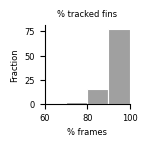

In [50]:
bins=np.arange(0,110,10)

fig, ax = plt.subplots(facecolor='None',figsize=(4*cm_, 4*cm_))

ax.set_ylabel('Fraction', fontsize=f_size)
sns.histplot(data=l_r_tracked_frames_perc, bins=bins, edgecolor='w', color='gray', kde=False)
ax.set_title('% tracked fins', fontsize=f_size)
ax.set_xlabel('% frames', fontsize=f_size)
ax.set_xlim(60,100)
ax.tick_params(axis='both', which='major', labelsize=f_size)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

fig.savefig( figure_path / 'tracking_percent_fins_pooled.pdf', dpi =dpi)
fig.savefig( figure_path / 'tracking_percent_fins_pooled.png', dpi =dpi)

In [48]:
# Assuming you have a list of tracking percentages for each session
tracking_percentages = tracked_frames_perc  # Replace this with your actual data

# Count sessions with over 90% well-tracked fins
well_tracked_count = sum(1 for percent in tracking_percentages if percent > 90)

# Calculate the percentage of sessions with over 90% well-tracked fins
total_sessions = len(tracking_percentages)
percentage_well_tracked = (well_tracked_count / total_sessions) * 100

print('Percentage of sessions with well-tracked fins > 90%: {:.2f}%'.format(percentage_well_tracked))


Percentage of sessions with well-tracked fins > 90%: 61.86%


In [49]:
# Assuming you have a list of tracking percentages for each session
tracking_percentages = l_r_tracked_frames_perc  # Replace this with your actual data

# Count sessions with over 90% well-tracked fins
well_tracked_count = sum(1 for percent in tracking_percentages if percent > 90)

# Calculate the percentage of sessions with over 90% well-tracked fins
total_sessions = len(tracking_percentages)
percentage_well_tracked = (well_tracked_count / total_sessions) * 100

print('Percentage of sessions with well-tracked fins > 90%: {:.2f}%'.format(percentage_well_tracked))

Percentage of sessions with well-tracked fins > 90%: 80.41%
